In [268]:
# Cell 2 — Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

In [269]:
# Cell 3 — Utilities
@dataclass
class Segment:
    start_frame: int
    end_frame: int

    @property
    def length_frames(self):
        return self.end_frame - self.start_frame + 1


def moving_average(x: np.ndarray, window: int) -> np.ndarray:
    if window <= 1:
        return x.astype(np.float32)
    window = int(window)
    kernel = np.ones(window, dtype=np.float32) / window
    return np.convolve(x, kernel, mode="same")


def postprocess_segments(segments, min_len_frames: int, merge_gap_frames: int):
    """Drop short segments + merge close segments."""
    if not segments:
        return []

    # Drop short
    segments = [s for s in segments if s.length_frames >= min_len_frames]
    if not segments:
        return []

    # Merge
    merged = [segments[0]]
    for s in segments[1:]:
        prev = merged[-1]
        gap = s.start_frame - prev.end_frame - 1
        if gap <= merge_gap_frames:
            merged[-1] = Segment(prev.start_frame, max(prev.end_frame, s.end_frame))
        else:
            merged.append(s)
    return merged


def hysteresis_binarize(signal: np.ndarray, th_high: float, th_low: float):
    """
    Hysteresis: enter when > th_high, stay on until < th_low
    Returns boolean array 'active' same length as signal.
    """
    active = np.zeros_like(signal, dtype=bool)
    on = False
    for i, v in enumerate(signal):
        if not on and v >= th_high:
            on = True
        elif on and v <= th_low:
            on = False
        active[i] = on
    return active


def mask_to_segments(active: np.ndarray):
    """Convert boolean mask to list of Segment."""
    segments = []
    in_seg = False
    start = 0
    for i, a in enumerate(active):
        if a and not in_seg:
            in_seg = True
            start = i
        elif (not a) and in_seg:
            in_seg = False
            segments.append(Segment(start, i - 1))
    if in_seg:
        segments.append(Segment(start, len(active) - 1))
    return segments

In [270]:
# Cell 4 — Motion curve via Optical Flow (مع ROI اختياري)
def compute_motion_curve(
    video_path: str,
    roi_mode: str = "upper",   # "full" أو "upper"
    resize_width: int = 320,   # تصغير لتسريع الحساب
    step: int = 1              # حساب كل step فريم
):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise FileNotFoundError(f"Cannot open video: {video_path}")

    fps = cap.get(cv2.CAP_PROP_FPS)
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    ret, frame = cap.read()
    if not ret:
        raise RuntimeError("Failed to read first frame")

    # resize
    h0, w0 = frame.shape[:2]
    if resize_width is not None and w0 > resize_width:
        scale = resize_width / w0
        frame = cv2.resize(frame, (int(w0 * scale), int(h0 * scale)))
    h, w = frame.shape[:2]

    # ROI
    def crop_roi(img):
        if roi_mode == "full":
            return img
        if roi_mode == "upper":
            # غالبًا الإشارة في الجزء العلوي
            return img[: int(h * 0.7), :]  # 70% من أعلى
        raise ValueError("roi_mode must be 'full' or 'upper'")

    prev = cv2.cvtColor(crop_roi(frame), cv2.COLOR_BGR2GRAY)

    motion = []
    frame_indices = [0]

    idx = 0
    while True:
        # Skip frames if step>1
        for _ in range(step):
            ret, frame = cap.read()
            idx += 1
            if not ret:
                cap.release()
                motion = np.array(motion, dtype=np.float32)
                frame_indices = np.array(frame_indices, dtype=int)
                return motion, frame_indices, fps, total

        if resize_width is not None and w0 > resize_width:
            frame = cv2.resize(frame, (w, h))

        gray = cv2.cvtColor(crop_roi(frame), cv2.COLOR_BGR2GRAY)

        # Farneback optical flow
        flow = cv2.calcOpticalFlowFarneback(
            prev, gray, None,
            pyr_scale=0.5, levels=3, winsize=15,
            iterations=3, poly_n=5, poly_sigma=1.2, flags=0
        )
        mag, _ = cv2.cartToPolar(flow[..., 0], flow[..., 1])

        # motion energy (متوسط magnitude)
        motion_val = float(np.mean(mag))
        motion.append(motion_val)
        frame_indices.append(idx)

        prev = gray

In [271]:
def hysteresis_binarize_var(signal, th_high_arr, th_low_arr):
    active = np.zeros_like(signal, dtype=bool)
    on = False
    for i, v in enumerate(signal):
        if not on and v >= th_high_arr[i]:
            on = True
        elif on and v <= th_low_arr[i]:
            on = False
        active[i] = on
    return active

In [272]:
def fill_short_gaps(active: np.ndarray, max_gap_frames: int) -> np.ndarray:
    """
    Turn short OFF gaps (False runs) into True if they are between two True regions.
    Example: True ... False False ... True  => fill if gap length <= max_gap_frames
    """
    active = active.copy().astype(bool)
    n = len(active)
    i = 0
    while i < n:
        if active[i]:
            i += 1
            continue

        # start of a False run
        j = i
        while j < n and not active[j]:
            j += 1
        gap_len = j - i

        left_true  = (i - 1 >= 0 and active[i - 1])
        right_true = (j < n and active[j])

        if left_true and right_true and gap_len <= max_gap_frames:
            active[i:j] = True

        i = j
    return active

In [273]:
def segment_video_by_motion(
    video_path: str,
    roi_mode: str = "upper",
    resize_width: int = 320,
    step: int = 1,
    smooth_window: int = 7,
    th_high_percentile: float = 85.0,  # (مش مستخدم هنا، سيبه عادي)
    th_low_ratio: float = 0.6,         # (مش مستخدم هنا، سيبه عادي)
    min_len_sec: float = 0.25,
    merge_gap_sec: float = 0.15
):
    motion, frame_idx, fps, total_frames = compute_motion_curve(
        video_path=video_path,
        roi_mode=roi_mode,
        resize_width=resize_width,
        step=step
    )

    motion = motion.astype(np.float32)
    motion_s = moving_average(motion, smooth_window)

    # --- Local adaptive thresholds (windowed mean/std) ---
    win = max(5, int(fps * 1.0))  # 1 sec window
    local_mean = moving_average(motion_s, win)
    local_var  = moving_average((motion_s - local_mean)**2, win)
    local_std  = np.sqrt(np.maximum(local_var, 1e-8))

    th_high_arr = local_mean + 1.15 * local_std
    th_low_arr  = local_mean + 0.65 * local_std

    # Hysteresis with variable thresholds
    active = hysteresis_binarize_var(motion_s, th_high_arr, th_low_arr)

    # Smooth the binary mask itself (tolerance)
    kernel = np.ones(max(1, int(fps * 0.25)))
    active = np.convolve(active.astype(float), kernel, mode="same") > 0

    #  Fill short OFF gaps داخل نفس الإشارة (ده اللي بيلم القطعتين)
    active = fill_short_gaps(active, max_gap_frames=max(1, int(fps * 0.6)))  # 0.6 sec

    segs = mask_to_segments(active)

    # Convert segment indices (in motion array) to real frame indices using frame_idx
    real_segs = []
    for seg in segs:
        start_frame = int(frame_idx[seg.start_frame + 1])
        end_frame   = int(frame_idx[seg.end_frame + 1])
        real_segs.append(Segment(start_frame, end_frame))

    # Postprocess: drop short + merge close
    min_len_frames = max(1, int(min_len_sec * fps))
    merge_gap_frames = max(0, int(merge_gap_sec * fps))
    real_segs = postprocess_segments(real_segs, min_len_frames, merge_gap_frames)

    info = {
        "fps": fps,
        "total_frames": total_frames,
        "th_high_arr": th_high_arr,
        "th_low_arr": th_low_arr,
        "motion_raw": motion,
        "motion_smooth": motion_s,
        "frame_idx": frame_idx,
        "active_mask": active
    }
    return real_segs, info

In [274]:
# Cell 6 — Run on your video
video_path = "/content/ام_يحب_طفل.mp4"   # <-- غيّر المسار
segments, info = segment_video_by_motion(
    video_path,
    roi_mode="full",           #you can use full
    resize_width=320,
    step=1,
    smooth_window=11,
    th_high_percentile=92,
    th_low_ratio=0.6,
    min_len_sec=0.30,
    merge_gap_sec=0.45
)

print("FPS:", info["fps"])
print("Thresholds:", {"high": info["th_high_arr"], "low": info["th_low_arr"]})
print("Segments (#):", len(segments))
for i, s in enumerate(segments, 1):
    print(i, "frames:", (s.start_frame, s.end_frame),
          "seconds:", (s.start_frame/info["fps"], s.end_frame/info["fps"]))

FPS: 25.0
Thresholds: {'high': array([0.27215424, 0.2785247 , 0.2844169 , 0.28988272, 0.29492965,
       0.29957545, 0.3038323 , 0.30774054, 0.31125128, 0.3145295 ,
       0.31748715, 0.32049644, 0.32457423, 0.31521934, 0.30291754,
       0.2875489 , 0.26917928, 0.24777919, 0.22290957, 0.19971812,
       0.17817865, 0.16123775, 0.14796859, 0.1383014 , 0.13218755,
       0.12624021, 0.12024964, 0.11410468, 0.10792714, 0.10188204,
       0.09621575, 0.09110083, 0.0865256 , 0.0822105 , 0.07847453,
       0.07495648, 0.07236056, 0.06919175, 0.06601959, 0.06283163,
       0.05962793, 0.05644502, 0.05325435, 0.05007259, 0.04706492,
       0.044478  , 0.04259322, 0.04180476, 0.04169648, 0.04288377,
       0.04559018, 0.04969596, 0.0545117 , 0.06018028, 0.06653056,
       0.0733594 , 0.0801862 , 0.08644199, 0.09301774, 0.10004026,
       0.10784757, 0.11714869, 0.1285953 , 0.14213131, 0.16277027,
       0.18629025, 0.21202087, 0.23881184, 0.26356262, 0.29072028,
       0.3156156 , 0.33742985, 

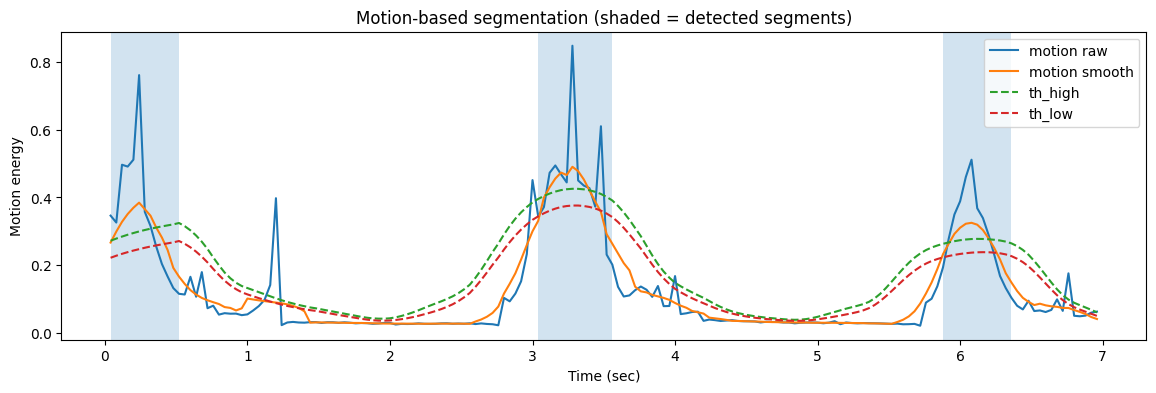

In [275]:
# Cell 7 — Plot motion curve + segments
motion = info["motion_raw"]
motion_s = info["motion_smooth"]
fps = info["fps"]
frame_idx = info["frame_idx"]

# x-axis: time for each motion point (ends at frame_idx[i+1])
t = frame_idx[1:] / fps

plt.figure(figsize=(14, 4))
plt.plot(t, motion, label="motion raw")
plt.plot(t, motion_s, label="motion smooth")
plt.plot(t, info["th_high_arr"], linestyle="--", label="th_high")
plt.plot(t, info["th_low_arr"], linestyle="--", label="th_low")

for s in segments:
    plt.axvspan(s.start_frame/fps, s.end_frame/fps, alpha=0.2)

plt.xlabel("Time (sec)")
plt.ylabel("Motion energy")
plt.legend()
plt.title("Motion-based segmentation (shaded = detected segments)")
plt.show()

In [276]:
# Cell 8 (اختياري) — قصّ المقاطع إلى فيديوهات منفصلة
import os

def export_segments(video_path: str, segments, out_dir="segments_out"):
    os.makedirs(out_dir, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise FileNotFoundError(f"Cannot open: {video_path}")
    fps = cap.get(cv2.CAP_PROP_FPS)

    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    fourcc = cv2.VideoWriter_fourcc(*"mp4v")

    for i, seg in enumerate(segments, 1):
        out_path = os.path.join(out_dir, f"seg_{i:03d}_{seg.start_frame}_{seg.end_frame}.mp4")
        writer = cv2.VideoWriter(out_path, fourcc, fps, (w, h))

        cap.set(cv2.CAP_PROP_POS_FRAMES, seg.start_frame)
        for f in range(seg.start_frame, seg.end_frame + 1):
            ret, frame = cap.read()
            if not ret:
                break
            writer.write(frame)
        writer.release()

    cap.release()
    return out_dir

export_dir = export_segments(video_path, segments, out_dir="segments_out")
print("Saved to:", export_dir)

Saved to: segments_out
